In [1]:
## imports

import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis

from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import linregress

import mtspec

# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors

%load_ext autoreload
%autoreload 2

In [2]:
from defs import EOF_SST_analysis, trim_axs, Nino34_timeseries, Nino_timeseries, Zonal_SST_gradient

In [3]:
figwidth1 = 8.3;
figwidth2 = 12;
labelfontsize = 13;
legendfontsize = 12;
titlefontsize = 13;

## Load HadISST observations

In [15]:
## HadISST data
## https://www.metoffice.gov.uk/hadobs/hadisst/data/download.html
## 1870 - 2020 SST data

file = 'observations/HadISST/HadISST_sst.nc'
ds   = xr.open_dataset(file)

# select last 100 years
ds = ds.sel(time=slice("1920", "2019"))

# -180 to 180 transform to 0 - 360
ds.coords['longitude'] = (ds.coords['longitude'] - 360) % 360
ds = ds.sortby(ds.longitude)
ds = ds.sortby(ds.latitude)

# select tropical pacific
minlat = -23;  maxlat = 23; minlon = 140; maxlon = 280;
ds = ds.sel(latitude = slice(minlat, maxlat)).sel(longitude = slice(minlon, maxlon))

# Nino3.4 index
Nino4_hadisst = ds.sst.where(ds.latitude<5).where(ds.latitude>-5).where(ds.longitude>160).where(ds.longitude<210).mean(dim='latitude').mean(dim='longitude')
Nino4_hadisst = Nino4_hadisst.groupby('time.month') - Nino4_hadisst.groupby('time.month').mean(dim='time')

Nino34_hadisst = ds.sst.where(ds.latitude<5).where(ds.latitude>-5).where(ds.longitude>190).where(ds.longitude<240).mean(dim='latitude').mean(dim='longitude')
Nino34_hadisst = Nino34_hadisst.groupby('time.month') - Nino34_hadisst.groupby('time.month').mean(dim='time')

Nino3_hadisst = ds.sst.where(ds.latitude<5).where(ds.latitude>-5).where(ds.longitude>210).where(ds.longitude<270).mean(dim='latitude').mean(dim='longitude')
Nino3_hadisst = Nino3_hadisst.groupby('time.month') - Nino3_hadisst.groupby('time.month').mean(dim='time')

Nino12_hadisst = ds.sst.where(ds.latitude<0).where(ds.latitude>-10).where(ds.longitude>270).where(ds.longitude<280).mean(dim='latitude').mean(dim='longitude')
Nino12_hadisst = Nino12_hadisst.groupby('time.month') - Nino12_hadisst.groupby('time.month').mean(dim='time')

# eofs, without climatology
n = 1
ssts = ds.sst.groupby('time.month') - ds.sst.groupby('time.month').mean(dim='time')

solver = Eof(ssts, weights=None, center=True)
eofs = solver.eofsAsCovariance(neofs=n)
pcs  = solver.pcs(npcs=n, pcscaling=1)
varF = solver.varianceFraction(neigs=n)
hadisst_eofs = xr.merge([eofs, pcs, varF])

hadisst_varf = hadisst_eofs.variance_fractions.isel(mode=0).values
eof_hadisst = hadisst_eofs.eofs.isel(mode=0)

minlat = -5;  maxlat = 5; minlon = 190; maxlon = 240; #Nino3.4
mean = eof_hadisst.sel(latitude = slice(minlat, maxlat)).sel(longitude = slice(minlon, maxlon)).mean(dim='latitude').mean(dim='longitude')
if mean<0: eof_hadisst = -eof_hadisst;

eof_hadisst = eof_hadisst/np.std(eof_hadisst)

# correlation of Nino3.4 with PC1
PC = hadisst_eofs.pcs.isel(mode=0)
hadisst_corr4  = np.abs(np.corrcoef(Nino4_hadisst.values, PC.values)[0,1])
hadisst_corr34 = np.abs(np.corrcoef(Nino34_hadisst.values, PC.values)[0,1])
hadisst_corr3  = np.abs(np.corrcoef(Nino3_hadisst.values, PC.values)[0,1])
hadisst_corr12 = np.abs(np.corrcoef(Nino12_hadisst.values, PC.values)[0,1])
hadisst_corr = hadisst_corr34;

# annual mean ssts
AM_ssts = ds.sst.mean(dim='time')

# correlation of annual mean state with leading EOF
Ninolike_hadisst = np.corrcoef(AM_ssts.values[~np.isnan(AM_ssts.values)], eof_hadisst.values[~np.isnan(eof_hadisst.values)])[0,1]

### PlioMIP1 data

In [11]:
## Import Brierley figure 8 
# extracted via WebPlotDigitizer & via contact with Chris
#
# x = Change-ENSO pattern correlation
# y = ENSO amplitude change (%)

P1_models  = ['CCSM4', 'COSMOS', 'FGOALS-g2', 'GISS-E2-R', 'HadCM3', 'IPSLCM5A', 'MIROC4m', 'MRI2.3', 'NorESM-L']
P1_pi_sd   = np.array([1.02, 1.79, 0.61, 0.47, 0.71, 0.61, 0.47, 0.67, 0.69])
P1_plio_sd = np.array([0.84, 1.44, 0.44, 0.43, 0.57, 0.54, 0.31, 0.67, 0.31])
P1_sd_change = 100*(P1_plio_sd - P1_pi_sd)/P1_pi_sd;
P1_corr_change = np.array([-0.28, 0.45, 0.09, -0.37, -0.28, -0.20, 0.01, 0., 0.32])


## load Model data

In [5]:
modellist = ['CCSM4', 'CCSM4-UoT', 'CCSM4-Utr', 'CESM1.2', 'CESM2', 'COSMOS', 'EC-Earth3.3',
             'GISS2.1G', 'HadCM3', 'HadGEM3', 'IPSLCM5A', 'IPSLCM5A2', 'IPSLCM6A', 'MIROC4m', 
             'MRI2.3', 'NorESM-L', 'NorESM1-F']


## EOF analysis

# **Appendix Figure 3**

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


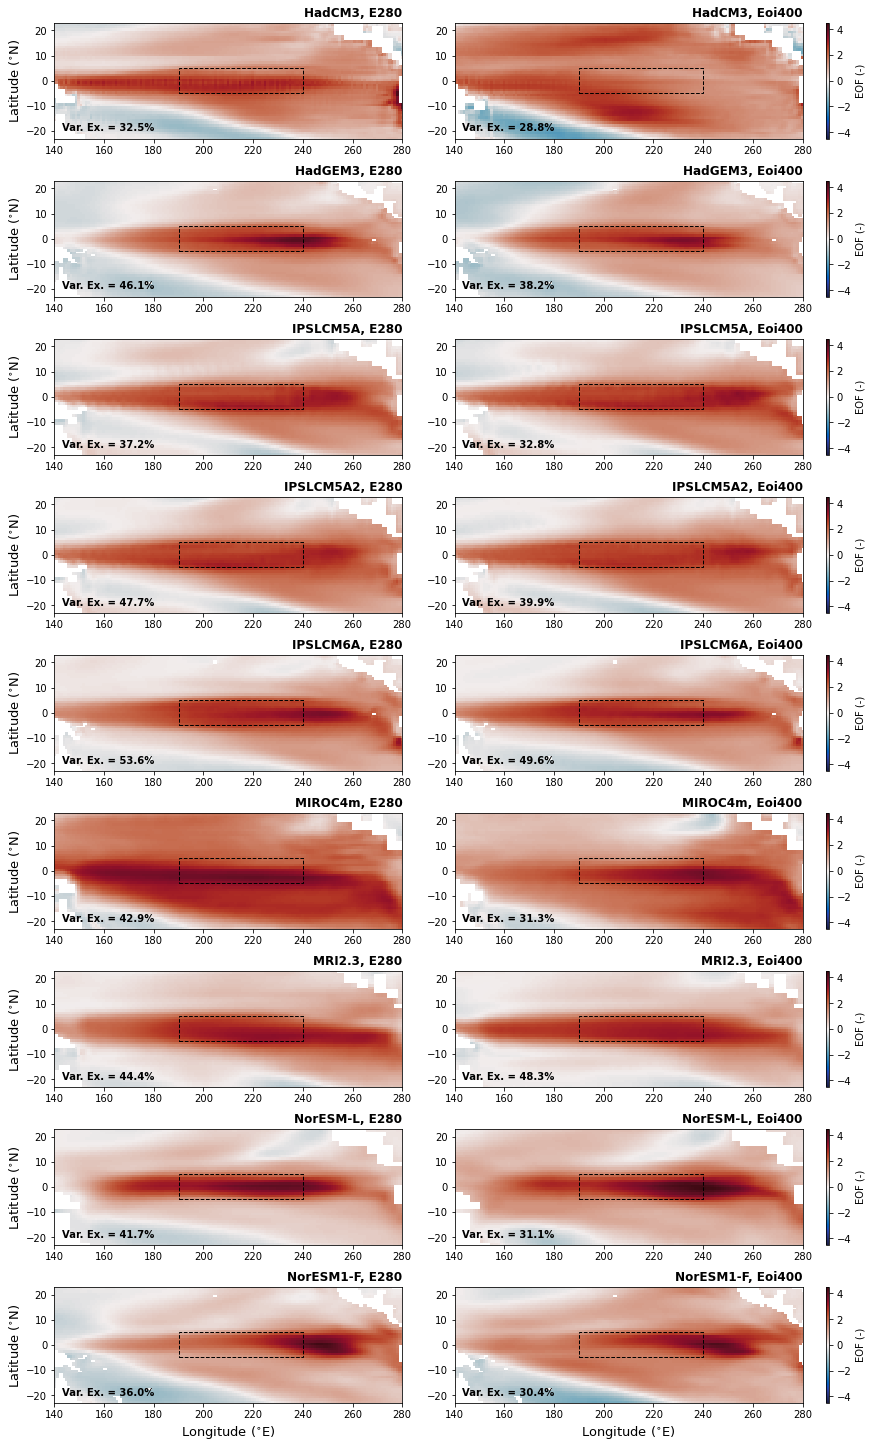

In [30]:
# if figtype == 'all':
#     N_models = len(modellist);    
#     skip = 0;
#     figlen = 40;
# elif figtype == 'first9':
#     N_models = 9;
#     skip = 0;
#     figlen = 20;
# elif figtype == 'last8':
#     N_models = 8;
#     skip = 9;
#     figlen = 18;

figtype = 'last9'

if figtype == 'all':
    N_models = len(modellist);    
    skip = 0;
    figlen = 40;
elif figtype == 'first8':
    N_models = 9;
    skip = -1;
    figlen = 20;
elif figtype == 'last9':
    N_models = 9;
    skip = 8;
    figlen = 20;    
    
vmin = -4.5; vmax = 4.5; cmap = plt.get_cmap('cmo.balance');    
    
fig1, axs = plt.subplots(nrows = N_models, ncols=2, figsize=(figwidth2, figlen), constrained_layout=True)
axs = trim_axs(axs, 2*N_models)

# varf_e280   = np.zeros(N_models)
# varf_eoi400 = np.zeros(N_models)
# corr_e280   = np.zeros((N_models,4))
# corr_eoi400 = np.zeros((N_models,4))

for ax, i in zip(axs, range(2*N_models)):

    if np.mod(i,2)==0:   run = 'E280'
    elif np.mod(i,2)==1: run = 'EOI400'

    i_model = skip + np.int(np.floor(i/2)) 
    
    if figtype=='first8' and i==0:
        eof1 = eof_hadisst
        varf = hadisst_varf
        title = 'HadISST 1920-2020'
    else:
        model = modellist[i_model]

        eofs = EOF_SST_analysis(model, run, weights=None, n=1)
        eof1 = eofs.eofs.isel(mode=0)

        #define EOF so that it is positive in the Nino3.4 region
        minlat = -5;  maxlat = 5; minlon = 190; maxlon = 240; #Nino3.4
        mean = eof1.where(eof1.latitude>minlat).where(eof1.latitude<maxlat).where(eof1.longitude>minlon).where(eof1.longitude<maxlon).mean(dim='latitude').mean(dim='longitude')
        if mean<0: eof1 = -eof1;

        #normalise by spatial std dev
        eof1 = eof1 / eof1.std()

        # calculate variance fraction and include in plot    
        varf = eofs.variance_fractions.isel(mode=0).values
        
        if run=='EOI400': run2 = 'Eoi400';
        else: run2 = run;
        title = f'{model}, {run2}'
    
    # plot
    if figtype=='first8' and i==0:
        eof1.plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=False)
        ax.set_ylabel('Latitude ($^{\circ}$N)', fontsize = labelfontsize)
    elif figtype=='first8' and i==1:
        eof1.plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=False)
        ax.set_ylabel('')
    elif np.mod(i,2)==0:
        eof1.plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=False)
        ax.set_ylabel('Latitude ($^{\circ}$N)', fontsize = labelfontsize)
    else:
        eof1.plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=True, cbar_kwargs = dict(label='EOF (-)'))
        ax.set_ylabel('')
    
    ax.set_xlim(140,280)
    ax.set_ylim(-23,23)
    if i>2*N_models-3: ax.set_xlabel('Longitude ($^{\circ}$E)', fontsize = labelfontsize)
    else: ax.set_xlabel('')

    ax.set_title(title, loc='right', fontsize=12, fontweight = 'bold')
    ax.set_title('')
    
    # draw Nino3.4 region
    ax.add_patch(Rectangle((190,-5),50,10, fill=False, linestyle='--'));
    ax.text(143, -20, f'Var. Ex. = {100*varf:.1f}%', fontweight = 'bold')
    
    if figtype == 'first8' and i==1:
        ax.clear()
        ax.axis('off')

    
#     #calculate correlation of Nino3.4 index with PC1
#     PC   = eofs.pcs.isel(mode=0)   
#     nino4  = Nino_timeseries(model, run, mode='Nino4')
#     nino34 = Nino_timeseries(model, run, mode='Nino34')
#     nino3  = Nino_timeseries(model, run, mode='Nino3')
#     nino12 = Nino_timeseries(model, run, mode='Nino12')
    
#     corr4  = np.abs(np.corrcoef(nino4.values, PC.values[:1200])[0,1])
#     corr34 = np.abs(np.corrcoef(nino34.values, PC.values[:1200])[0,1])
#     corr3  = np.abs(np.corrcoef(nino3.values, PC.values[:1200])[0,1])
#     corr12 = np.abs(np.corrcoef(nino12.values, PC.values[:1200])[0,1])
#     corr   = [corr4, corr34, corr3, corr12]
    
#     # include variancefrac + Nino3.4 correlation in plot
# #     ax.text(143, -20, f'Var = {100*varf:.1f}%,   Corr = {corr:.2f}', fontweight = 'bold')
#     ax.text(143, 18, f'P_4 = {corr[0]:.2f}')    
#     ax.text(143, 13, f'P34 = {corr[1]:.2f}')    
#     ax.text(143,  8, f'P_3 = {corr[2]:.2f}')
#     ax.text(143,  3, f'P12 = {corr[3]:.2f}')
        
#     # save for mean EOF
#     if i_model==0: 
#         if run=='E280':     
#             eof1_e280 = eof1; 
#             poscount_e280 = 1*(eof1>0);
#         elif run=='EOI400': 
#             eof1_eoi400 = eof1; 
#             poscount_eoi400 = 1*(eof1>0);
#     else:
#         if run=='E280':     
#             eof1_e280 = eof1_e280 + eof1.values;
#             poscount_e280 = poscount_e280 + 1*(eof1>0).values;            
#         elif run=='EOI400': 
#             eof1_eoi400 = eof1_eoi400 + eof1.values;
#             poscount_eoi400 = poscount_eoi400 + 1*(eof1>0).values; 
            
#     if run=='E280':
#         eof_old = eof1;
#     elif run=='EOI400':
#         diff = eof1 - eof_old;
#         if i_model==0:
#             poscount_diff = 1*(diff>0);
#         else:
#             poscount_diff = poscount_diff + 1*(diff>0).values;        

#     # save varF & corr
#     if run=='E280':
#         varf_e280[i_model]   = varf
#         corr_e280[i_model,:]   = corr
#     elif run=='EOI400':
#         varf_eoi400[i_model] = varf
#         corr_eoi400[i_model,:] = corr
                           
# save final data
# EM_eof1_e280   = eof1_e280/len(modellist)
# EM_eof1_eoi400 = eof1_eoi400/len(modellist)
# EM_varf_e280   = np.mean(varf_e280)
# EM_varf_eoi400 = np.mean(varf_eoi400)
# EM_corr_e280   = np.mean(corr_e280, axis=0)
# EM_corr_eoi400 = np.mean(corr_eoi400, axis=0)
                
# plt.savefig('figures/first_eofs_v3.png', bbox_inches='tight', dpi=200)
plt.savefig('figures/appendixfigure3b.pdf', bbox_inches='tight')

# **Figure 5**

<ipython-input-38-00aae32cb56d>:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(poscount_e280.longitude, poscount_e280.latitude, y1*y2*g, alpha=0., hatch=hatching)
<ipython-input-38-00aae32cb56d>:58: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(poscount_e280.longitude, poscount_e280.latitude, y1*y2*g, alpha=0., hatch=hatching)
<ipython-input-38-00aae32cb56d>:73: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same di

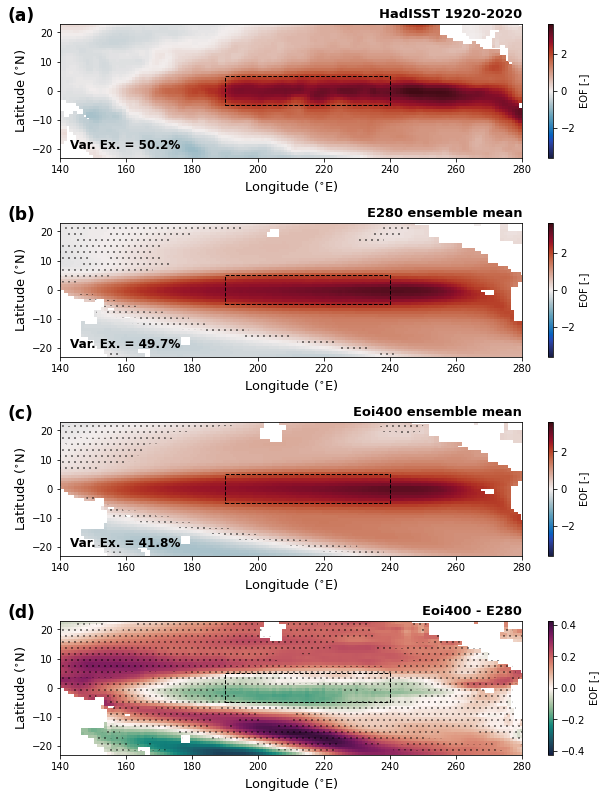

In [38]:
fig2, axs = plt.subplots(nrows=4, ncols=1, figsize=(8.3,11), constrained_layout=True)

caption = True;
textx = 124; texty = 24; 

plt.rcParams['hatch.linewidth'] = 0.3;

lats = [-23, 23]
lons = [140, 280]

vmin = -3.6; vmax = 3.6; cmap = plt.get_cmap('cmo.balance')

a = EM_eof1_e280
b = EM_eof1_eoi400

d = 5; hatching = '..';

ax=axs[0]
(eof_hadisst).plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cbar_kwargs = dict(label='EOF [-]'))
ax.set_title('HadISST 1920-2020', loc='right', fontsize=titlefontsize, fontweight = 'bold')
ax.set_xlim(lons[0], lons[1]); ax.set_ylim(lats[0], lats[1]);
ax.set_xlabel('Longitude ($^{\circ}$E)', fontsize=labelfontsize)
ax.set_ylabel('Latitude ($^{\circ}$N)', fontsize=labelfontsize)
ax.set_title('')
ax.text(143, -20, f'Var. Ex. = {100*hadisst_varf:.1f}%', fontweight = 'bold', fontsize=legendfontsize)
ax.add_patch(Rectangle((190,-5),50,10, fill=False, linestyle='--'));
if caption == True: ax.text(textx, texty, '(a)', fontsize = 17, fontweight = 'bold')

ax=axs[1]
p = a.plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cbar_kwargs = dict(label='EOF [-]'))
ax.set_title('E280 ensemble mean', loc='right', fontsize=titlefontsize, fontweight = 'bold')
ax.set_xlim(lons[0], lons[1]); ax.set_ylim(lats[0], lats[1]);
ax.set_xlabel('Longitude ($^{\circ}$E)', fontsize=labelfontsize)
ax.set_ylabel('Latitude ($^{\circ}$N)', fontsize=labelfontsize)
ax.set_title('')
ax.text(143, -20, f'Var. Ex. = {100*EM_varf_e280:.1f}%', fontweight = 'bold', fontsize=legendfontsize)
ax.add_patch(Rectangle((190,-5),50,10, fill=False, linestyle='--'));

y1 = np.ma.masked_where((poscount_e280.values>len(modellist)-d), poscount_e280.values)
y2 = np.ma.masked_where((poscount_e280.values<d+1), poscount_e280.values)
g=np.ma.masked_where(a==np.nan, a)
ax.pcolor(poscount_e280.longitude, poscount_e280.latitude, y1*y2*g, alpha=0., hatch=hatching)
if caption == True: ax.text(textx, texty, '(b)', fontsize = 17, fontweight = 'bold')

ax=axs[2]
b.plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cbar_kwargs = dict(label='EOF [-]'))
ax.set_title('Eoi400 ensemble mean', loc='right', fontsize=titlefontsize, fontweight = 'bold')
ax.set_xlim(lons[0], lons[1]); ax.set_ylim(lats[0], lats[1]);
ax.set_xlabel('Longitude ($^{\circ}$E)', fontsize=labelfontsize)
ax.set_ylabel('Latitude ($^{\circ}$N)', fontsize=labelfontsize)
ax.set_title('')
ax.text(143, -20, f'Var. Ex. = {100*EM_varf_eoi400:.1f}%', fontweight = 'bold', fontsize=legendfontsize)
ax.add_patch(Rectangle((190,-5),50,10, fill=False, linestyle='--'));

y1 = np.ma.masked_where((poscount_eoi400.values>len(modellist)-d), poscount_eoi400.values)
y2 = np.ma.masked_where((poscount_eoi400.values<d+1), poscount_eoi400.values)
g=np.ma.masked_where(b==np.nan, b)
ax.pcolor(poscount_e280.longitude, poscount_e280.latitude, y1*y2*g, alpha=0., hatch=hatching)
if caption == True: ax.text(textx, texty, '(c)', fontsize = 17, fontweight = 'bold')

ax=axs[3]
(b-a).plot(ax=ax, cmap=plt.get_cmap('cmo.curl'), cbar_kwargs = dict(label='EOF [-]'))
ax.set_title('Eoi400 - E280', loc='right', fontsize=titlefontsize, fontweight = 'bold')
ax.set_xlim(lons[0], lons[1]); ax.set_ylim(lats[0], lats[1]);
ax.set_xlabel('Longitude ($^{\circ}$E)', fontsize=labelfontsize)
ax.set_ylabel('Latitude ($^{\circ}$N)', fontsize=labelfontsize)
ax.set_title('')
ax.add_patch(Rectangle((190,-5),50,10, fill=False, linestyle='--'));

y1 = np.ma.masked_where((poscount_diff.values>len(modellist)-d), poscount_diff.values)
y2 = np.ma.masked_where((poscount_diff.values<d+1), poscount_diff.values)
g=np.ma.masked_where((b-a)==np.nan, (b-a))
ax.pcolor(poscount_e280.longitude, poscount_e280.latitude, y1*y2*g, alpha=0., hatch=hatching)
if caption == True: ax.text(textx, texty, '(d)', fontsize = 17, fontweight = 'bold')


# plt.savefig('figures/mean_eofs_v3.png', bbox_inches='tight', dpi=200)
# plt.savefig('figures/mean_eofs_v4.pdf', bbox_inches='tight')
# plt.savefig('figures/figure5.pdf', bbox_inches='tight')

### Variance explanation + Nino3.4 & PC1 correlation

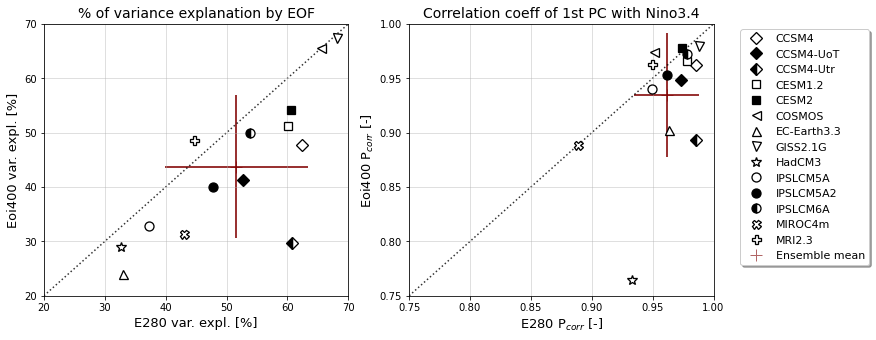

In [149]:
xlist = [100*varf_e280,   corr_e280[:,1]]
ylist = [100*varf_eoi400, corr_eoi400[:,1]]

xlabels = [r'E280 var. expl. [%]',   r'E280 P$_{corr}$ [-]']
ylabels = [r'Eoi400 var. expl. [%]', r'Eoi400 P$_{corr}$ [-]']
titles = ['% of variance explanation by EOF', 'Correlation coeff of 1st PC with Nino3.4']

xminlist = [20, .75]
xmaxlist = [70,  1.0]

markers = ['D', 'D', 'D', 's', 's', '<', '^', 'v', '*', 'o', 'o', 'o', 'X', 'P']
msize   = [8,    8,   8,   8,   8,   9,   9,   9,  10,   9,   9,   9,   9,   9]
colors  = ['w', 'k', 'w', 'w', 'k', 'w', 'w', 'w', 'w', 'w', 'k', 'w', 'w', 'w']
fillstyles = ['full', 'full', 'right', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'right', 'full', 'full']

fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(12,5))

for j in range(2):
    
    ax = axs[j]
    x = xlist[j]; y = ylist[j]
    xmin = xminlist[j]; xmax = xmaxlist[j]
    
    # plot model values
    for i in range(len(modellist)):
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor ='k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
            
    # plot ensemble mean +- std dev
    emcolor = 'maroon'
    ax.plot(np.mean(x), np.mean(y), color = emcolor, linestyle = 'None', marker ='+', markersize = 12, label = 'Ensemble mean', zorder=-1, alpha=0.6)    
    ax.plot([np.mean(x) - np.std(x), np.mean(x) + np.std(x)], [np.mean(y), np.mean(y)], 
        '-', color = emcolor, zorder=-1, linewidth=2, alpha=0.8)
    ax.plot([np.mean(x), np.mean(x)], [np.mean(y) - np.std(y), np.mean(y) + np.std(y)], 
        '-', color = emcolor, zorder=-1, linewidth=2, alpha=0.8)
 
    # grid
    ax.grid(alpha=0.5);
    ax.plot([xmin, xmax],[xmin, xmax],'k:', alpha=0.8, zorder = -1);
    ax.plot([xmin, xmax], [0,0], 'k-', alpha=0.6, zorder=-1, linewidth=1)
    ax.plot([0,0], [xmin, xmax], 'k-', alpha=0.6, zorder=-1, linewidth=1)

    # legend
    if j==1:
#         chartBox = ax.get_position()
#         ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*1, chartBox.height])
        ax.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1, fontsize=11)
    
    ax.set_xlim([xmin, xmax]); ax.set_ylim([xmin, xmax])
    ax.set_xlabel(xlabels[j], fontsize=13)
    ax.set_ylabel(ylabels[j], fontsize=13)
    ax.set_title(titles[j], fontsize=14)
    
# plt.savefig('figures/eof_varf_pcorr.png', bbox_inches='tight', dpi=200)

### Calculate Nino3.4 std

In [9]:
## Calculate Nino34 index time series 

std_e280    = np.zeros(len(modellist))
std_eoi400  = np.zeros(len(modellist))

trend_type = "linear" # linear detrending of Nino34 series

for i in range(0, len(modellist)):
    
    print('model = ' + modellist[i])
    
    ds = Nino34_timeseries(model = modellist[i], run='E280', trend = trend_type)
    if i==0: 
        nino_e280   = np.zeros((len(ds), len(modellist)))    
        nino_eoi400 = np.zeros((len(ds), len(modellist))) 
        
    nino_e280[:,i]   = ds
    nino_eoi400[:,i] = Nino34_timeseries(model = modellist[i], run='EOI400', trend = trend_type)
    
    std_e280[i]    = np.std(nino_e280[:,i])
    std_eoi400[i]  = np.std(nino_eoi400[:,i])    

model = CCSM4
model = CCSM4-UoT


KeyboardInterrupt: 

## Correlation of the Annual Mean SST change with the leading E280 EOF

In [10]:
# Ninolike_e280   = np.zeros(len(modellist))  # E280 annual mean to E280 EOF
# Ninolike_eoi400 = np.zeros(len(modellist))  # Eoi400 annual mean to Eoi400 EOF
Ninolike        = np.zeros(len(modellist))  # Eoi400 - E280 annual mean change to E280 EOF

for i in range(len(modellist)):

    model = modellist[i]
    print(model)

    run = 'E280'
    EOF1 = EOF_SST_analysis(model, run, weights = None, n = 1).eofs.isel(mode=0)
    #define EOF so that it is positive in the Nino3.4 region
    mean = EOF1.where(EOF1.latitude>-5).where(EOF1.latitude<5).where(EOF1.longitude>190).where(EOF1.longitude<240).mean(dim='latitude').mean(dim='longitude')
    if mean < 0: EOF1 = -EOF1.values;
    else: EOF1 = EOF1.values
    
    AMT1 = Zonal_SST_gradient(model, run, latbound = 23, latmean=False).values
    AMT1 = (AMT1 - np.nanmean(AMT1))/np.nanstd(AMT1)
#     Ninolike_e280[i] = np.corrcoef(AMT1[~np.isnan(AMT1)], EOF1[~np.isnan(EOF1)])[0,1]

    run = 'Eoi400'
    EOF2 = EOF_SST_analysis(model, run, weights = None, n = 1).eofs.isel(mode=0)
    #define EOF so that it is positive in the Nino3.4 region
    mean = EOF2.where(EOF2.latitude>-5).where(EOF2.latitude<5).where(EOF2.longitude>190).where(EOF2.longitude<240).mean(dim='latitude').mean(dim='longitude')
    if mean < 0: EOF2 = -EOF2.values;
    else: EOF2 = EOF2.values
            
    AMT2 = Zonal_SST_gradient(model, run, latbound = 23, latmean=False).values
    AMT2 = (AMT2 - np.nanmean(AMT2))/np.nanstd(AMT2)
#     Ninolike_eoi400[i] = np.corrcoef(AMT2[~np.isnan(AMT2)], EOF2[~np.isnan(EOF2)])[0,1]
    
    ## correlate annual mean change (eoi400 - e280) to E280 leading EOF:
    Ninolike[i] = np.corrcoef((AMT2-AMT1)[~np.isnan(AMT2-AMT1)], EOF1[~np.isnan(AMT2-AMT1)])[0,1]


CCSM4
CCSM4-UoT
CCSM4-Utr


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


CESM1.2
CESM2
COSMOS


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarra

EC-Earth3.3


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/py

GISS2.1G
HadCM3
HadGEM3
IPSLCM5A
IPSLCM5A2
IPSLCM6A


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


MIROC4m
MRI2.3
NorESM-L
NorESM1-F


In [11]:
x = Ninolike
for i in range(len(modellist)):
    print(f'{x[i]:.2f}, {modellist[i]}')
print(f'{np.mean(x):.2f}, mean')
print(f'{np.std(x):.2f}, std')

-0.31, CCSM4
0.37, CCSM4-UoT
-0.62, CCSM4-Utr
-0.03, CESM1.2
0.63, CESM2
0.54, COSMOS
-0.47, EC-Earth3.3
0.51, GISS2.1G
-0.12, HadCM3
0.48, HadGEM3
-0.03, IPSLCM5A
0.09, IPSLCM5A2
0.53, IPSLCM6A
-0.03, MIROC4m
-0.10, MRI2.3
-0.04, NorESM-L
-0.14, NorESM1-F
0.07, mean
0.36, std


# **Figure 10**

<ipython-input-12-d74c4c4e487b>:8: RuntimeWarning: invalid value encountered in true_divide
  y = 100*(std_eoi400 - std_e280)/std_e280


NameError: name 'P1_corr_change' is not defined

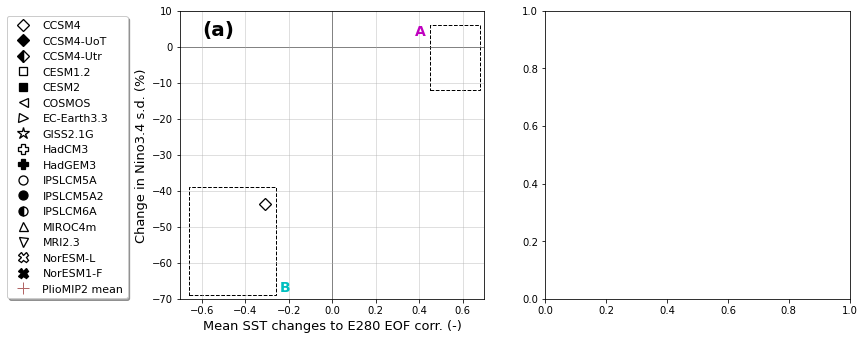

In [12]:
fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(12, 5.3))

caption=True;

ax=axs[0]

x = Ninolike
y = 100*(std_eoi400 - std_e280)/std_e280
xlims = [-0.7, 0.7]; ylims = [-70, 10];

markers = ['D', 'D', 'D', 's', 's', '<', '>', '*', 'P', 'P', 'o', 'o', 'o', '^', 'v', 'X', 'X']
msize   = [8,    8,   8,   8,   8,   9,   9,  13,  10,   10,   9,   9,   9,   9,   9,  10,  10]
colors  = ['w', 'k', 'w', 'w', 'k', 'w', 'w', 'w', 'w', 'k', 'w', 'k', 'w', 'w', 'w', 'w', 'k']
fillstyles = ['full', 'full', 'right', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 
              'full', 'right', 'full', 'full', 'full', 'full']

for i in range(len(modellist)):
    ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
    markeredgecolor ='k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)

emcolor = 'maroon'
ax.plot(np.mean(x), np.mean(y), color = emcolor, linestyle = 'None', marker ='+', markersize = 12, label = 'PlioMIP2 mean', zorder=-1, alpha=0.6)    
ax.plot([np.mean(x) - np.std(x), np.mean(x) + np.std(x)], [np.mean(y), np.mean(y)], 
    '-', color = emcolor, zorder=-1, linewidth=2, alpha=0.8)
ax.plot([np.mean(x), np.mean(x)], [np.mean(y) - np.std(y), np.mean(y) + np.std(y)], 
    '-', color = emcolor, zorder=-1, linewidth=2, alpha=0.8)   
    
# slope, intercept, r_value, p_value, std_err = linregress(x, y)
# xp = np.sort(x); yp = xp* slope + intercept
# ax.plot(xp,yp,'--', color = emcolor, label='PlioMIP2 fit', zorder=-1)
# ax.text(-0.6,-55, f'R$^2$ = {np.float(np.round(r_value**2,2))}', fontsize=12, color=emcolor);    

# grid
ax.grid(alpha=0.5);
# ax.plot(xlims, xlims,'k:', alpha=0.8, zorder = -1);
ax.plot(xlims, [0,0], 'k-', alpha=0.6, zorder=-1, linewidth=1)
ax.plot([0,0], ylims, 'k-', alpha=0.6, zorder=-1, linewidth=1)
ax.set_xlim(xlims); ax.set_ylim(ylims)

ax.legend(loc='upper center', bbox_to_anchor=(-.37, 1), shadow=True, ncol=1, fontsize=11)
ax.set_ylabel('Change in Nino3.4 s.d. (%)', fontsize=labelfontsize); 
ax.set_xlabel('Mean SST changes to E280 EOF corr. (-)', fontsize=labelfontsize);

ax.add_patch(Rectangle((0.45,-12),0.23,18, fill=False, linestyle='--'));
ax.text(0.38, 3, 'A', fontsize=14, fontweight='bold', color='m')

ax.add_patch(Rectangle((-0.66,-69),0.40,30, fill=False, linestyle='--'));
ax.text(-0.24, -68, 'B', fontsize=14, fontweight='bold', color='c')

if caption==True: ax.text(-0.6, 3, '(a)', fontsize=20, fontweight ='bold')

ax=axs[1]

markers = ['D',  '<', 'd', '*', 'P', 'o',  '^', 'v', 'X']
msize   = [8,     9,   9,  13,  10,   9,    9,   9,   10]
colors  = ['w',  'w', 'w', 'w', 'w', 'w',  'w', 'w', 'w']
fillstyles = ['full', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full']


x = P1_corr_change; y= P1_sd_change;
for i in range(len(P1_models)):
    ax.plot(x[i], y[i], label = P1_models[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
    markeredgecolor ='k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
    
    
## PlioMIP1
col = 'darkgreen'; emcolor=col;
ax.plot(np.mean(x), np.mean(y), color = emcolor, linestyle = 'None', marker ='+', markersize = 12, label = 'PlioMIP1 mean', zorder=-1, alpha=0.6)    
ax.plot([np.mean(x) - np.std(x), np.mean(x) + np.std(x)], [np.mean(y), np.mean(y)], 
    '-', color = emcolor, zorder=-1, linewidth=2, alpha=0.8)
ax.plot([np.mean(x), np.mean(x)], [np.mean(y) - np.std(y), np.mean(y) + np.std(y)], 
    '-', color = emcolor, zorder=-1, linewidth=2, alpha=0.8)      
    
# slope, intercept, r_value, p_value, std_err = linregress(x,y)
# xp = np.sort(x); yp = xp* slope + intercept
# ax.plot(xp,yp,'--', color=col, label='PlioMIP1 fit', zorder=-1)
# ax.text(0.3,-40, f'R$^2$ = {np.float(np.round(r_value**2,2))}', fontsize=12, color=col);      
    
# grid
ax.grid(alpha=0.5);
# ax.plot(xlims, xlims,'k:', alpha=0.8, zorder = -1);
ax.plot(xlims, [0,0], 'k-', alpha=0.6, zorder=-1, linewidth=1)
ax.plot([0,0], ylims, 'k-', alpha=0.6, zorder=-1, linewidth=1)
ax.set_xlim(xlims); ax.set_ylim(ylims)

ax.legend(loc='upper center', bbox_to_anchor=(1.22, 1), shadow=True, ncol=1, fontsize=11)

ax.set_ylabel('Change in Nino3.4 s.d. (%)', fontsize=labelfontsize); 
ax.set_xlabel('Mean SST changes to PreInd EOF corr. (-)', fontsize=labelfontsize);
# ax.set_title('Correlation of Trop.Pac. mean state change to leading E280 EOF (23S-23N, 140E-280E)',fontsize=13)

if caption==True: ax.text(-0.6, 3, '(b)', fontsize=17, fontweight ='bold')

# plt.savefig('figures/meanchange2EOF_corr.png', bbox_inches='tight', dpi=200)
# plt.savefig('figures/meanchange2EOF_corr.pdf', bbox_inches='tight')
# plt.savefig('figures/figure10.pdf', bbox_inches='tight')

### El Nino-like cluster vs. La Nina-like cluster

In [18]:
## cluster modellen met hogere correlatie mean state changes vs PI ENSO patroon 
##    EN en near-zero change in ENSO amplitude
## GISS, COSMOS, IPSLCM6A, CESM2

# models_ = ['CESM2', 'COSMOS', 'GISS2.1G', 'IPSLCM6A']
models_ = ['CCSM4', 'CCSM4-Utr', 'EC-Earth3.3']
# models_ = ['CCSM4-UoT', 'HadGEM3']

latbounds = 23

for i in range(len(models_)):
    model = models_[i]

    run = 'E280'
    EOF1 = EOF_SST_analysis(model, run, latbound = latbounds, weights = None, n = 1).eofs.isel(mode=0)
    #define EOF so that it is positive in the Nino3.4 region
    mean = EOF1.where(EOF1.latitude>-5).where(EOF1.latitude<5).where(EOF1.longitude>190).where(EOF1.longitude<240).mean(dim='latitude').mean(dim='longitude')
    if mean < 0: EOF1 = -EOF1.values;
    else: EOF1 = EOF1.values

    AMT1 = Zonal_SST_gradient(model, run, latbound = latbounds, latmean=False).values
#     AMT1 = (AMT1 - np.nanmean(AMT1))/np.nanstd(AMT1)
    # Ninolike_e280[i] = np.corrcoef(AMT1[~np.isnan(AMT1)], EOF1[~np.isnan(EOF1)])[0,1]

    run = 'Eoi400'
    EOF2 = EOF_SST_analysis(model, run, latbound = latbounds, weights = None, n = 1).eofs.isel(mode=0)
    #define EOF so that it is positive in the Nino3.4 region
    mean = EOF2.where(EOF2.latitude>-5).where(EOF2.latitude<5).where(EOF2.longitude>190).where(EOF2.longitude<240).mean(dim='latitude').mean(dim='longitude')
    if mean < 0: EOF2 = -EOF2.values;
    else: EOF2 = EOF2.values

    AMT2 = Zonal_SST_gradient(model, run, latbound = latbounds, latmean=False).values
#     AMT2 = (AMT2 - np.nanmean(AMT2))/np.nanstd(AMT2)
    # Ninolike_eoi400[i] = np.corrcoef(AMT2[~np.isnan(AMT2)], EOF2[~np.isnan(EOF2)])[0,1]

    ## correlate annual mean change (eoi400 - e280) to E280 leading EOF:
    print(f'{model}, corr = {np.corrcoef((AMT2-AMT1)[~np.isnan(AMT2-AMT1)], EOF1[~np.isnan(AMT2-AMT1)])[0,1]}')
    
        # save for mean EOF
    if i==0: 
        tempdiff = AMT2 - AMT1
        PIeof    = EOF1
    else:
        tempdiff = tempdiff + (AMT2 - AMT1)
        PIeof    = PIeof + EOF1

tempdiff2 = tempdiff/len(models_)
PIeof2    = PIeof/len(models_)
        
# fig,ax = plt.subplots(1,2, figsize=(12,5))

# ax[0].pcolormesh(tempdiff)
# ax[1].pcolormesh(PIeof)

CCSM4, corr = -0.31907134321418246


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


CCSM4-Utr, corr = -0.5819766809273071


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarra

EC-Earth3.3, corr = -0.4419149746410989


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


# **Figure 11**

<ipython-input-79-69706a1fe305>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x,y,zlist[i], vmin=vminlist[j_ax], vmax = vmaxlist[j_ax], cmap = cmaps[j_ax])


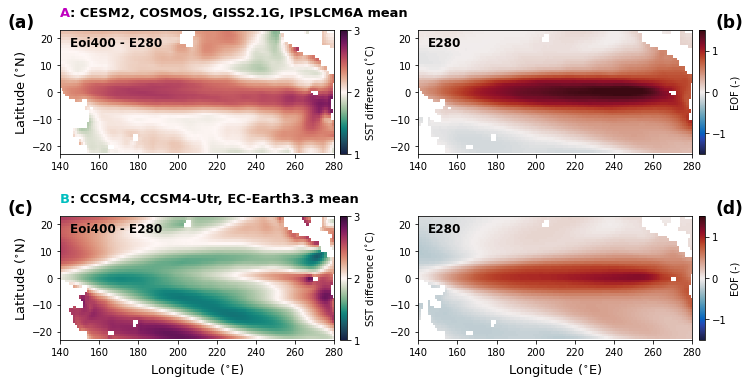

In [79]:
A = Zonal_SST_gradient(model, run, latbound = latbounds, latmean=False)
x = A.longitude.values; y = A.latitude.values;

caption = True;
textx = [113, 292, 113, 292]; texty = [24, 24, 24, 24]; textlist = ['(a)', '(b)', '(c)', '(d)'];

zlist = [tempdiff1, PIeof1, tempdiff2, PIeof2] #, tempdiff3, PIeof3]
# zlist = [tempdiff1-np.nanmean(tempdiff1[:]), PIeof1, tempdiff2-np.nanmean(tempdiff2[:]), PIeof2]

titles = [': CESM2, COSMOS, GISS2.1G, IPSLCM6A mean',': CCSM4, CCSM4-Utr, EC-Earth3.3 mean'] #,  'CCSM4-UoT, HadGEM3 mean']
titles1 = ['A', 'B']; colors = ['m', 'c']
vminlist = [1, -1.5]; vmaxlist = [3, 1.5];
cmaps = ['cmo.curl', 'cmo.balance']
labels = ['SST difference ($^{\circ}$C)', 'EOF (-)']
texts = ['Eoi400 - E280', 'E280']
tickslist = [[1,2,3], [-1,0,1]]

fig = plt.figure(figsize=(12,5.7))    
# fig = plt.figure(figsize=(12,8))    
gs = gridspec.GridSpec(ncols=2, nrows=2, height_ratios=[1, 1])
fig.subplots_adjust(hspace=.5, wspace=.15)

for i in range(4):
    i_ax = np.int(np.floor(i/2)); j_ax = np.int(np.mod(i,2))
#     ax = axs[i_ax, j_ax]

    ax=fig.add_subplot(gs[i_ax,j_ax])                     
                         
    im = ax.pcolormesh(x,y,zlist[i], vmin=vminlist[j_ax], vmax = vmaxlist[j_ax], cmap = cmaps[j_ax])
    fig.colorbar(im, ax=ax, label=labels[j_ax], fraction=0.1, pad =0.02, ticks=tickslist[j_ax])
#     ax.set_title('Eoi400 - E280', loc='right', fontsize=titlefontsize, fontweight = 'bold')
    ax.set_xlim([140, 280]); ax.set_ylim([-23, 23]);
    if i_ax==1:
        ax.set_xlabel('Longitude ($^{\circ}$E)', fontsize=labelfontsize)
    if j_ax==0:
        ax.set_ylabel('Latitude ($^{\circ}$N)', fontsize=labelfontsize)
        ax.text(140, 28, titles1[i_ax], color=colors[i_ax], fontsize=titlefontsize, fontweight = 'bold')
        ax.text(145, 28, titles[i_ax], fontsize=titlefontsize, fontweight = 'bold')

#         ax.set_title(titles[i_ax], loc='left', pad = 14, fontsize=titlefontsize, fontweight = 'bold')
    ax.text(145, 17, texts[j_ax], fontsize = legendfontsize, fontweight='bold')
#     ax.set_title('')
    
    ax.text(textx[i], texty[i], textlist[i], fontsize=17, fontweight = 'bold')

# plt.savefig('figures/figure11.pdf', bbox_inches='tight')